# Testing Embeddings by Length

In [1]:
# Import everything required for this notebook
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

import numpy as np

import matplotlib.pyplot as plt

## Define Mean Pooling, and Embedding Params

I use a pretrained embedding model `nomic-ai/nomic-embed-text-v1` which I download from huggingface. I use this model because it's very lightweight and still quite performant. It has a fairly low number of dimensions ~700.

Mean pooling over an attention mask is used - the attention mask weights each token's embedding such that more important tokens contribute more to the output embedding.

In [2]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('nomic-ai/nomic-embed-text-v1', trust_remote_code=True)
model.eval()
_ = model

<All keys matched successfully>


## Define Embedding Function

Here we define our embedding function - it uses mean pooling over an attention mask to create an embedding from the model output.
The attention mask is obtained from the encoded input.



In [3]:
def embed_texts(passages):
    encoded_input = tokenizer(passages, padding=True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        model_output = model(**encoded_input)
    
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings

## Define Similarity

This is the dot product of two normalised vectors.
Similarity tells you how related two embeddings are.

In [4]:
def similarity(veca, vecb):
    maga, magb = 0, 0
    dotprod = 0
    for a,b in zip(veca, vecb):
        maga += a*a
        magb += b*b
        dotprod += a*b
    mag = (maga*magb)**0.5
    return dotprod/mag

## Define Our Test Text

I pulled something of MS teams - Sam J made a post about GRPC error codes and retrying which I thought was appropriate.

In [5]:
target = "Gourmet underground fungal fruiting body"
request = """A truffle is a type of edible fungus that grows underground, often near the roots of certain trees like oaks and hazelnuts, with which they form a symbiotic relationship.
They are highly prized in the culinary world for their unique, intense aroma and flavor, which can vary significantly depending on the species and their growing conditions.
Truffles are typically found using trained animals, such as dogs or pigs, that can detect their strong scent through the soil.
There are many varieties of truffles, including the highly coveted white truffles (Tuber magnatum) from Italy and the black truffles (Tuber melanosporum) from France, among others.
Due to their scarcity, difficulty to cultivate, and high demand, truffles are considered one of the most expensive foods in the world."""

## Split Text into Variable Length Pieces

I name this variable `corpus` - which is a list of strings which slowly build up in length to the request.
`corpus` is chunked every ten characters so that we can run this in a reasonable amount of time.

i.e. the contents of `corups` will be:
```
[
  'A',
  'A ',
  'A t',
  'A tr',
  'A tru',
  'A truf',
  'A truff',
  'A truffl',
  'A truffle',
  'A truffle ',
  'A truffle i',
  'A truffle is',
  ...
]
```

In [6]:
corpus = []

for i in range(1,len(request),1):
    corpus.append(request[:i])

## Create Embeddings
We now create an embedding for the 'target' which is our title - or the text we want to match to.

We also create embeddings for each member of the corpus. This is SLOW and will take a while!

In [7]:
target_embedding = embed_texts([target])[0]

In [8]:
corpus_embeddings = embed_texts(corpus)

## Create Similarities and Compare

Finally we compare the similarity between the target embedding and each member of the corpus.

In [9]:
sims = []
for i, e in enumerate(corpus_embeddings):
    sims.append(similarity(target_embedding,e))

## Plot Similarity change over Length

We now plot the similarity as a function of the length of the input string.
Excitingly we see that increases rather quickly up to ~ 0.58 and eventually (after ~430 chars) reaches its peak. We see step changes in the embedding which may correspond to certain keywords being hit (GRPC, message, retry).
This needs more investigation to be conclusive.

Text(0, 0.5, 'Similarity to title')

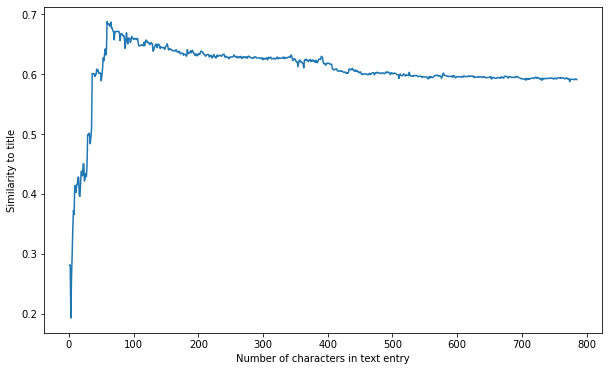

In [11]:
text_length = range(1,len(request),1)

plt.figure(figsize=(10,6))
plt.plot(text_length, sims)
plt.xlabel("Number of characters in text entry")
plt.ylabel("Similarity to title")

## Multi-Target Comparison

Comparisons with multiple titles is cheap to do - we do not need to re-embed the entire corpus again (which is painful) - we only have to consider the reasonably short titles!

This toy example shows that it is fairly easy to run lots of comparisons in one go.
Highly relevant titles match well, some vague titles (Message sending strategy) match better than the specific, highly relevant titles that get better scores later on.

Text(0, 0.5, 'Similarity to title')

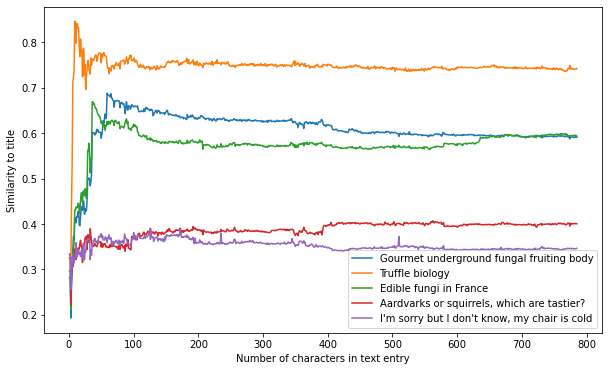

In [13]:
text_length = range(1,len(request),1)

targets = ["Gourmet underground fungal fruiting body", "Truffle biology", "Edible fungi in France",
           "Aardvarks or squirrels, which are tastier?",
           "I'm sorry but I don't know, my chair is cold"]
target_embeddings = embed_texts(targets)

plt.figure(figsize=(10,6))

for targ, t_emb in zip(targets, target_embeddings):
    sims = []
    for i, e in enumerate(corpus_embeddings):
        sims.append(similarity(t_emb,e))

    plt.plot(text_length, sims, label=targ)

plt.legend(loc="lower right")
plt.xlabel("Number of characters in text entry")
plt.ylabel("Similarity to title")